In [156]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
import seaborn as sns
from shapely.geometry import Point, LineString, MultiPoint
import numpy as np
import contextily as ctx
import requests
from io import StringIO, BytesIO
import json
import datetime as dt

# Challenge description

**Goals**<br>
Based on the data collected and its analysis, we would like to have a tool that allows
citizens to plan outdoor activities regarding the air quality.<br>
**Outcome**<br>
This problem has several layers that can be tackled, starting from a fundamental solution
to something more advanced:
1. A daily predictive model for the air quality of the city of Cascais;
2. Explanation of the prediction of the air quality and possible measures for reducing
it, specifically in the areas where outdoor activities are performed;
3. Suggest outdoor activities depending on the predicted air quality.

# Data

## Activities

In [35]:
dataset = {}
files = {'Beaches': 'https://dadosabertos.cascais.pt/pt_PT/dataset/84f6042c-8fd0-4d87-8e8a-40f8df36c7ca/resource/796b33f5-6cbb-4c8a-a2b0-5669e7ebb25d/download/mnlinhaagua.geojson',
#        'Playgrounds': 'https://dadosabertos.cascais.pt/dataset/d345ebe5-2936-4bbb-b598-6637cf44b730/resource/240461d3-cad8-47e6-bdbc-42ef233e43b1/download/mnparqueinfantil.geojson',
       'Green_Areas': 'https://dadosabertos.cascais.pt/pt_PT/dataset/540192d4-c591-4779-885d-94cd957901ea/resource/df652290-f595-47c5-9ec8-fda3b3571891/download/mnestruturaverde.geojson',
       'Gardens': 'https://dadosabertos.cascais.pt/pt_PT/dataset/ca2633ef-e192-4aaa-aa94-77d07024bbc3/resource/afa883ea-3aed-440e-9c9b-ea249593d7c3/download/mnhorta.geojson',
       'City_Parks': 'https://dadosabertos.cascais.pt/pt_PT/dataset/81f7f741-06cc-4e5d-be4b-fd627c7f0bfc/resource/6a999394-b0f0-4564-a4c3-34e993832988/download/mnparquejardim.geojson',
       'Water_Lines': 'https://dadosabertos.cascais.pt/pt_PT/dataset/84f6042c-8fd0-4d87-8e8a-40f8df36c7ca/resource/796b33f5-6cbb-4c8a-a2b0-5669e7ebb25d/download/mnlinhaagua.geojson',
       'Water_Sports': 'https://dadosabertos.cascais.pt/dataset/89644571-f3dd-4262-8093-bf30fcadcbf3/resource/ced8220d-9e5c-4140-af14-b74a55a1f8ba/download/mnequipareadesportonautico.geojson',
       'Sports': 'https://dadosabertos.cascais.pt/dataset/a5a3d1af-9be3-4243-8683-73025df8e65c/resource/ba5c8ef8-7807-465d-b8d0-5c30b1e80798/download/mndesportonatureza.geojson',
#        'Sports_Infrastructure': 'https://dadosabertos.cascais.pt/dataset/e8a1e60c-35af-4579-92b5-4c3154e27bc3/resource/37b39d04-3542-4ed5-831d-ec9203a8c7f7/download/redeequipamentosdesportivoscascais2018.csv',
        }

# check faulty data

for key, val in files.items():
    print(f'downloading file: {key}')
    dataset[key] = gpd.read_file(val)
dataset.keys()

downloading file: Beaches
downloading file: Green_Areas
downloading file: Gardens
downloading file: City_Parks
downloading file: Water_Lines
downloading file: Water_Sports
downloading file: Sports


dict_keys(['Beaches', 'Green_Areas', 'Gardens', 'City_Parks', 'Water_Lines', 'Water_Sports', 'Sports'])

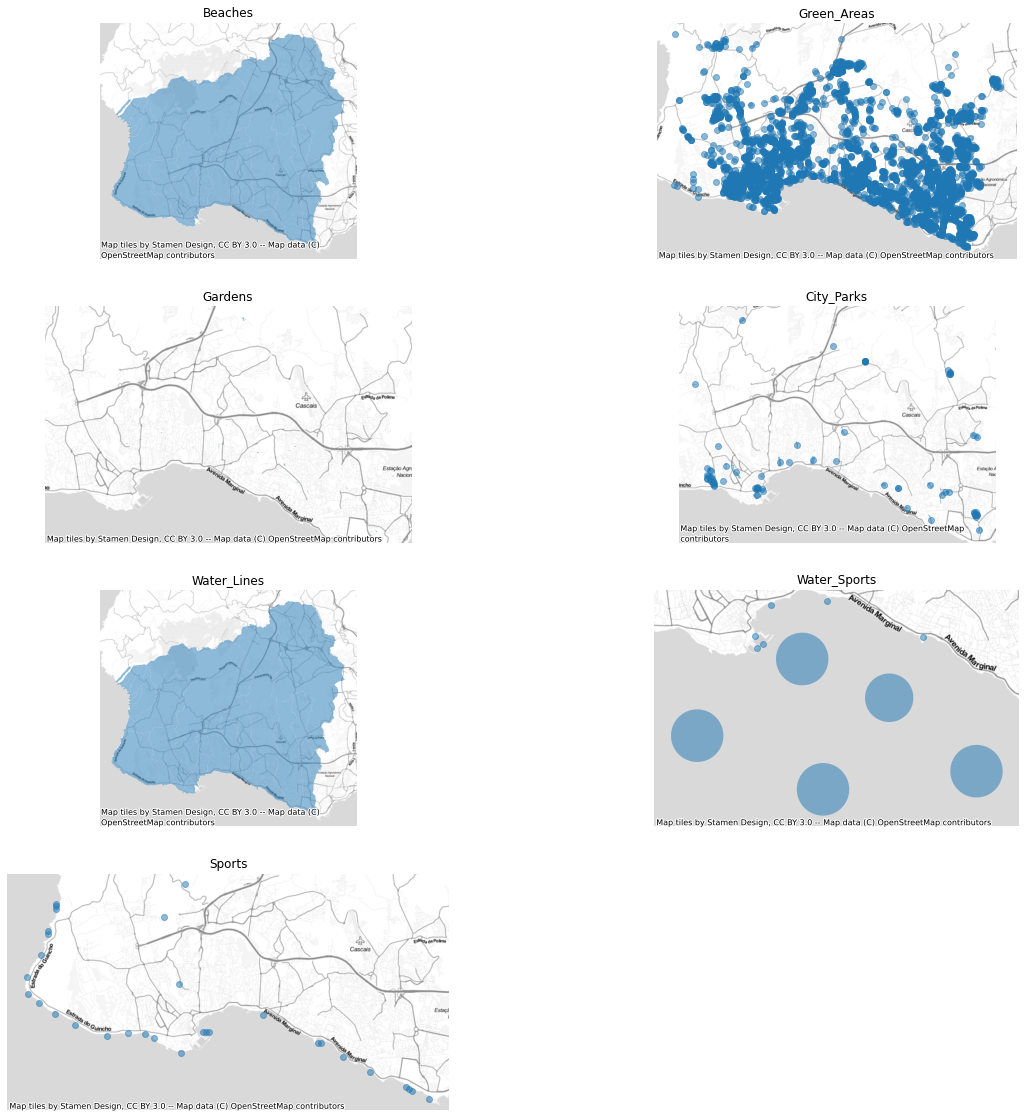

In [107]:
# show all outdoor activities
plt.figure(figsize=(20,20))
for i, (k,v) in enumerate(dataset.items()):
    ax = plt.subplot(4, 2, i+1)
    v = v.to_crs(epsg=3857)
    v.plot(ax=ax, alpha=.5)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=13)
    ax.set_axis_off()
    plt.title(k)

# make sure projection doesnt desturb us

## Sensor data

In [165]:
url = 'http://opendata-cascais.qart.pt/lastmeasurements'
r = requests.get(url)
dct = {c:x for c, x in enumerate(r.json())}
sensors = pd.DataFrame.from_dict(dct, orient='index')
sensors['time'] = pd.to_datetime(sensors.date, format='%Y%m%d%H%M')

In [166]:
sensors.head()

,id,date,dateStandard,value,unit,address,coordinates,time
0,QA00NO0001,202105150000,UTC,90.0,µg/m3,Parede,"{'x': 0, 'y': 0, 'z': 0, 'lat': 0, 'lng': 0}",2021-05-15
1,QA0NO20001,202105150000,UTC,83.0,µg/m3,Parede,"{'x': 0, 'y': 0, 'z': 0, 'lat': 0, 'lng': 0}",2021-05-15
2,QA00O30001,202105150000,UTC,48.0,µg/m3,Parede,"{'x': 0, 'y': 0, 'z': 0, 'lat': 0, 'lng': 0}",2021-05-15
3,QAPM250001,202105150000,UTC,3.0,µg/m3,Parede,"{'x': 0, 'y': 0, 'z': 0, 'lat': 0, 'lng': 0}",2021-05-15
4,QAPM100001,202105150000,UTC,11.0,µg/m3,Parede,"{'x': 0, 'y': 0, 'z': 0, 'lat': 0, 'lng': 0}",2021-05-15


**Note**<br>
- Coordinates n/a
- time is only 15/05/2021

<AxesSubplot:>

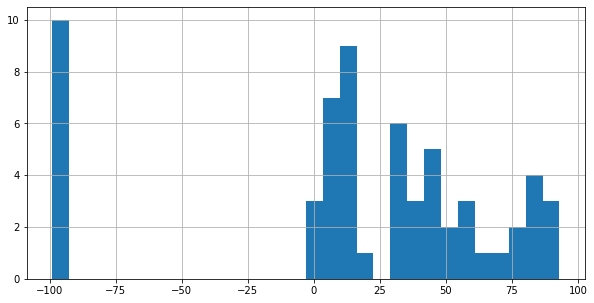

In [183]:
# plot range of pollution 
# ONLY Microgram
mcgram = sensors[sensors.unit == 'µg/m3']
mcgram.value.hist(bins=30, figsize=(10,5))

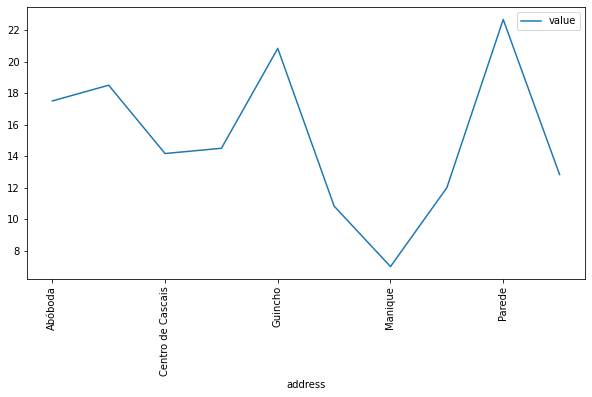

In [185]:
# plot pollution by areas
# ONLY Microgram
mcgram.groupby('address').mean().plot(figsize=(10,5))
plt.xticks(rotation=90)
plt.show()

# Suggestions

As soon as we have a time series and coordinates of the sensors:
- .sjoin outdoor activities with the sensors locations
- analyze which areas are polluted most and when
- give each area a target (amount of pollution at which time)

1. A daily predictive model for the air quality of the city of Cascais:
- create time series models for all areas together

2. Explanation of the prediction of the air quality and possible measures for reducing it, specifically in the areas where outdoor activities are performed:
- compare areas around activities vs. areas without activities in the vicinity
- analyze emmission sources around the peak times around activity areas

3. Suggest outdoor activities depending on the predicted air quality.
Unclear:
- how to put everything in one model to recommend areas for certain times?